# **Laboratorio 8**
- Joaquín Campos - 22155
- Sofía García - 22210
- Julio García Salas - 22076

## **Inciso 1**

In [0]:
# INCISO 1 — con el nuevo maestro: /Volumes/workspace/default/lab8/master_unico.csv
# Versión compatible con Serverless (sin cache/persist)

from pyspark.sql import functions as F
import pandas as pd

# -----------------------------------------------------------
# 0) Paths y verificación
# -----------------------------------------------------------
PARENT = "/Volumes/workspace/default/lab8"
PATH   = "/Volumes/workspace/default/lab8/master_unico.csv"

display(dbutils.fs.ls(PARENT))

print("=== master_unico.csv (inicio) ===")
try:
    raw = dbutils.fs.head(PATH, 2048)
    print(raw[:1000])
except Exception as e:
    print("[WARN] No se pudo leer cabecera con dbutils.fs.head:", e)

# -----------------------------------------------------------
# 1) Carga robusta: pandas (utf-8-sig) -> Spark, con fallback a spark.read.csv
# -----------------------------------------------------------
df_all = None
try:
    pdf = pd.read_csv(PATH, dtype=str, encoding="utf-8-sig", engine="python")
    pdf.columns = [c.strip() for c in pdf.columns]
    df_all = spark.createDataFrame(pdf)
    print("[OK] Cargado con pandas -> Spark")
except Exception as e:
    print("[WARN] pandas.read_csv falló, probando spark.read.csv. Error:", e)
    df_all = (
        spark.read.format("csv")
        .option("header", True)
        .option("multiLine", True)
        .option("escape", '"')
        .load(PATH)
        .toDF(*[c.strip() for c in spark.read.csv(PATH, header=True).columns])
    )
    print("[OK] Cargado con spark.read.csv")

# 🚫 NO usar cache()/persist() en Serverless (no soportado)
# Materializamos una vez con count() y seguimos
total_rows = df_all.count()
print(f"\nTotal filas en master_unico: {total_rows:,}")
print(f"Total columnas: {len(df_all.columns)}")
print("Columnas (primeras 15):", df_all.columns[:15])

# Helper is_empty seguro (evita .isEmpty() si no está disponible)
def is_empty(sdf):
    try:
        return sdf.isEmpty()
    except Exception:
        return sdf.limit(1).count() == 0

# -----------------------------------------------------------
# 2) Separación por “tablas”
# -----------------------------------------------------------
if "source_table" in df_all.columns:
    hechos_df    = df_all.filter(F.col("source_table") == "HECHOS")
    vehiculos_df = df_all.filter(F.col("source_table") == "VEHICULOS")
    personas_df  = df_all.filter(F.col("source_table") == "PERSONAS")
else:
    hechos_df = df_all.filter(F.col("tipo_eve_norm").isNotNull())
    vehiculos_df = df_all.filter(
        F.col("tipo_veh_norm").isNotNull() |
        F.col("color_std").isNotNull() |
        F.col("sexo_pil_norm").isNotNull() |
        F.col("edad_pil_num").isNotNull()
    )
    personas_df = df_all.filter(
        F.col("sexo_per_norm").isNotNull() |
        F.col("edad_per_num").isNotNull() |
        F.col("is_fallecido").isNotNull() |
        F.col("is_lesionado").isNotNull()
    )

print("\n=== Conteos por 'tabla' ===")
if "source_table" in df_all.columns:
    df_all.groupBy("source_table").count().orderBy("source_table").show(truncate=False)
else:
    print(f"Hechos: {hechos_df.count():,} | Vehículos: {vehiculos_df.count():,} | Personas: {personas_df.count():,}")

# -----------------------------------------------------------
# 3) Muestras .show()
# -----------------------------------------------------------
print("\n--- Muestra HECHOS ---")
hechos_cols = [c for c in [
    "anio_norm","mes_norm","dia_norm","hora_clean","franja_horaria","dow_num","dow_label",
    "depto_code","depto_name_std","muni_code","zona_ciudad_num","tipo_eve_norm","anio_mes"
] if c in hechos_df.columns]
hechos_df.select(*hechos_cols).show(10, truncate=False)

print("\n--- Muestra VEHICULOS ---")
veh_cols = [c for c in [
    "anio_norm","mes_norm","hora_clean","depto_code","tipo_eve_norm",
    "tipo_veh_norm","color_std","sexo_pil_norm","edad_pil_num","marca_veh","modelo_veh"
] if c in vehiculos_df.columns]
vehiculos_df.select(*veh_cols).show(10, truncate=False)

print("\n--- Muestra PERSONAS ---")
per_cols = [c for c in [
    "anio_norm","mes_norm","hora_clean","depto_code","tipo_eve_norm",
    "sexo_per_norm","edad_per_num","is_fallecido","is_lesionado"
] if c in personas_df.columns]
personas_df.select(*per_cols).show(10, truncate=False)

# -----------------------------------------------------------
# 4) Describe & Summary de numéricas (sin cache)
# -----------------------------------------------------------
def safe_describe_numeric(sdf, cols, title):
    cols_exist = [c for c in cols if c in sdf.columns]
    if not cols_exist or is_empty(sdf):
        print(f"\n[INFO] Sin filas o columnas para {title}")
        return
    casted = [F.col(c).cast("double").alias(c) for c in cols_exist]
    print(f"\n--- DESCRIBE: {title} ---")
    sdf.select(*casted).describe().show(truncate=False)
    print(f"\n--- SUMMARY: {title} ---")
    sdf.select(*casted).summary().show(truncate=False)

safe_describe_numeric(
    hechos_df,
    ["anio_norm","mes_norm","dia_norm","hora_clean","dow_num","depto_code","muni_code","zona_ciudad_num"],
    "HECHOS (tiempo y ubicación)"
)
safe_describe_numeric(
    vehiculos_df,
    ["anio_norm","depto_code","edad_pil_num"],
    "VEHICULOS (características/conductor)"
)
safe_describe_numeric(
    personas_df,
    ["anio_norm","depto_code","edad_per_num","is_fallecido","is_lesionado"],
    "PERSONAS (atributos/estado)"
)

# -----------------------------------------------------------
# 5) Vistas temporales
# -----------------------------------------------------------
df_all.createOrReplaceTempView("master_unico")
hechos_df.createOrReplaceTempView("hechos")
vehiculos_df.createOrReplaceTempView("vehiculos")
personas_df.createOrReplaceTempView("personas")

print("\n[OK] Vistas creadas: master_unico, hechos, vehiculos, personas (sin cache/persist)")


path,name,size,modificationTime
dbfs:/Volumes/workspace/default/lab8/_UNIFICADO.csv,_UNIFICADO.csv,10395125,1759426297000
dbfs:/Volumes/workspace/default/lab8/master_unico.csv,master_unico.csv,29043186,1759470343000


=== master_unico.csv (inicio) ===
[Truncated to first 2048 bytes]
source_table,anio_norm,mes_norm,dia_norm,hora_clean,franja_horaria,dow_num,dow_label,depto_code,depto_name_std,muni_code,zona_ciudad_num,tipo_eve_norm,anio_mes,color_std,tipo_veh_norm,sexo_pil_norm,edad_pil_num,sexo_per_norm,edad_per_num,is_fallecido,is_lesionado,marca_veh,modelo_veh,color_veh,color_v,tipo_v,modelo_v,source_file
HECHOS,2013,1,1,3,MADRUGADA,2,MARTES,1,GUATEMALA,106,,NAN,2013-01,,,,,,,,,,,,,,,2013.csv
HECHOS,2013,1,1,5,MADRUGADA,2,MARTES,1,GUATEMALA,101,,NAN,2013-01,,,,,,,,,,,,,,,2013.csv
HECHOS,2013,1,1,3,MADRUGADA,2,MARTES,1,GUATEMALA,108,,NAN,2013-01,,,,,,,,,,,,,,,2013.csv
HECHOS,2013,1,1,0,MADRUGADA,2,MARTES,19,ZACAPA,1901,,NAN,2013-01,,,,,,,,,,,,,,,2013.csv
HECHOS,2013,1,1,18,NOCHE,2,MARTES,19,ZACAPA,1901,,NAN,2013-01,,,,,,,,,,,,,,,2013.csv
HECHOS,2013,1,1,0,MADRUGADA,2,MARTES,5,ESCUINTLA,502,,NAN,2013-01,,,,,,,,,,,,,,,2013.csv
HECHOS,2013,1,1,11,MAÑANA,2,MARTES,9,QUETZALTENANGO,901,,NAN,2013-01,,,,,,

# Resumen técnico — `master_unico.csv`

## 1) Estructura general
- **Filas:** 298,164  
- **Columnas:** 29  
- **Tablas unificadas (en `source_table`):**
  - **HECHOS:** 76,759
  - **VEHICULOS:** 111,988
  - **PERSONAS:** 109,417

> El esquema contiene campos normalizados para tiempo (`anio_norm`, `mes_norm`, `dia_norm`, `hora_clean`, `franja_horaria`, `dow_num`, `dow_label`), ubicación (`depto_code`, `depto_name_std`, `muni_code`, `zona_ciudad_num`), tipología (`tipo_eve_norm`, `tipo_veh_norm`, `color_std`) y atributos específicos de vehículo/persona.

---

## 2) Ejemplos de registros (muestras)
- **HECHOS:** filas de 2013 con `MADRUGADA/MAÑANA`, presencia de códigos de departamento y municipio; `tipo_eve_norm` aparece como **`NAN`** en algunas filas tempranas (indica valores faltantes/no mapeados).
- **VEHICULOS:** registros de 2021 con `tipo_eve_norm` ya estandarizado (p.ej., `COLISION`, `DERRAPE`), `tipo_veh_norm` y `color_std` numéricos/categorizados.
- **PERSONAS:** registros de 2021 con `sexo_per_norm`, `edad_per_num` y banderas `is_fallecido`/`is_lesionado`.

---

## 3) Cobertura de campos clave (calidad de datos)
**HECHOS** (base: 76,759 filas)  
- `hora_clean`: 76,732 (≈ **99.96%** cobertura)  
- `dow_num`, `depto_code`, `muni_code`: 60,617 cada uno (≈ **79%** cobertura)  
- `zona_ciudad_num`: 8,153 (≈ **10.6%** cobertura; muy escaso, usar con cuidado)  
- Rango temporal: **2013–2023**

**VEHICULOS** (base: 111,988 filas)  
- `depto_code`: 87,552 (≈ **78.2%**)  
- `edad_pil_num`: 5,382 (≈ **4.8%**; muy baja, sesga análisis por edad del piloto)  
- Rango temporal: **2013–2023**

**PERSONAS** (base: 109,417 filas)  
- `depto_code`: 87,497 (≈ **80.0%**)  
- `edad_per_num`: 84,249 (≈ **77.0%**)  
- `is_fallecido`: media **1.0** y `is_lesionado`: media **0.0** → **la tabla PERSONAS representa fallecidos** (no lesionados).  
- Rango temporal: **2013–2023**

**Implicación:** para preguntas que requieran **lesionados**, se deben derivar desde HECHOS/VEHICULOS (si existe la codificación) o incorporar una fuente adicional; la tabla PERSONAS no aporta lesionados.

---

## 4) Estadística descriptiva (resumen útil)
**HECHOS**  
- `anio_norm` medio ≈ **2018.27**, distribución homogénea 2013–2023.  
- `hora_clean` media ≈ **13.69** (sesgo leve hacia tarde—noche).  
- `dow_num` media ≈ **4.34** (cercano a **jueves**), con ~21% faltantes.

**VEHICULOS**  
- `anio_norm` medio ≈ **2018.49**.  
- `edad_pil_num` media ≈ **33.0** (desvío ~11.4) sobre **solo 4.8%** de filas (no representativo si no se filtra).

**PERSONAS**  
- `anio_norm` medio ≈ **2018.12**.  
- `edad_per_num` media ≈ **31.0** (desvío ~16.26).  
- Banderas: `is_fallecido=1` y `is_lesionado=0` en **100%** de registros → confirma naturaleza de fallecidos.

---

## 5) Observaciones de normalización/categorización
- `tipo_eve_norm`: aparecen valores **`NAN`** en HECHOS (2013), señal de filas no clasificadas; conviene **completar/estandarizar** para no perderlas en agregaciones por tipo.  
- `color_std`, `tipo_veh_norm`: están presentes en VEHICULOS; coherentes con la normalización previa (mapeos numéricos/códigos).  
- `depto_name_std`: disponible en HECHOS, útil para rotular gráficos; en VEHICULOS/PERSONAS se prioriza `depto_code` (80%± cobertura).

---






## **Inciso 2**

In [0]:
# INCISO 2 — Años disponibles por tabla y validación de coincidencia
# Requiere que existan las vistas temporales: `hechos`, `vehiculos`, `personas`
# (quedan creadas por el bloque del inciso 1 sobre `master_unico.csv`)

from pyspark.sql import functions as F

def years_count_df(view_name: str, year_col: str = "anio_norm"):
    """
    Devuelve un DataFrame con: anio, count
    - Filtra solo años válidos (exactamente 4 dígitos).
    - Convierte a entero para ordenar correctamente.
    """
    df = spark.table(view_name)
    if year_col not in df.columns:
        raise ValueError(f"La vista '{view_name}' no tiene la columna '{year_col}'.")
    base = (
        df.select(F.col(year_col).cast("string").alias("y"))
          .filter(F.col("y").rlike(r"^\d{4}$"))
          .withColumn("anio", F.col("y").cast("int"))
    )
    return base.groupBy("anio").count().orderBy("anio")

def table_totals(view_name: str, year_col: str = "anio_norm"):
    """
    Retorna (total_filas, filas_con_anio_valido, df_por_anio)
    """
    df = spark.table(view_name)
    total = df.count()
    df_years = years_count_df(view_name, year_col)
    valid = df_years.agg(F.sum("count").alias("valid")).collect()[0]["valid"] or 0
    return total, valid, df_years

# 1) Conteos por año para cada tabla
tot_h, valid_h, hechos_y = table_totals("hechos")
tot_v, valid_v, vehiculos_y = table_totals("vehiculos")
tot_p, valid_p, personas_y = table_totals("personas")

print("=== Hechos: años disponibles y conteos ===")
display(hechos_y)
print(f"Registros con año válido: {valid_h:,} / total: {tot_h:,}\n")

print("=== Vehículos: años disponibles y conteos ===")
display(vehiculos_y)
print(f"Registros con año válido: {valid_v:,} / total: {tot_v:,}\n")

print("=== Personas (fallecidos): años disponibles y conteos ===")
display(personas_y)
print(f"Registros con año válido: {valid_p:,} / total: {tot_p:,}\n")

# 2) Validación de coincidencia de años entre tablas
H = set(r["anio"] for r in hechos_y.select("anio").distinct().collect())
V = set(r["anio"] for r in vehiculos_y.select("anio").distinct().collect())
P = set(r["anio"] for r in personas_y.select("anio").distinct().collect())

interseccion = sorted(H & V & P)
union_total = sorted(H | V | P)
faltan_en_H = sorted(set(union_total) - H)
faltan_en_V = sorted(set(union_total) - V)
faltan_en_P = sorted(set(union_total) - P)

print("=== Validación de años entre tablas ===")
print(f"Intersección (en TODAS): {interseccion}")
print(f"Unión (en ALGUNA):      {union_total}")
print(f"- HECHOS:    años ausentes vs unión → {faltan_en_H}")
print(f"- VEHICULOS: años ausentes vs unión → {faltan_en_V}")
print(f"- PERSONAS:  años ausentes vs unión → {faltan_en_P}")


=== Hechos: años disponibles y conteos ===


anio,count
2013,6324
2014,5651
2015,6854
2016,7964
2017,5879
2018,6395
2019,7047
2020,6350
2021,8153
2022,7924


Registros con año válido: 76,759 / total: 76,759

=== Vehículos: años disponibles y conteos ===


anio,count
2013,6323
2014,7904
2015,9823
2016,11618
2017,8644
2018,9514
2019,10827
2020,10103
2021,12796
2022,12239


Registros con año válido: 111,988 / total: 111,988

=== Personas (fallecidos): años disponibles y conteos ===


anio,count
2013,9060
2014,8990
2015,10397
2016,11668
2017,8625
2018,9407
2019,10664
2020,8142
2021,10544
2022,10722


Registros con año válido: 109,417 / total: 109,417

=== Validación de años entre tablas ===
Intersección (en TODAS): [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
Unión (en ALGUNA):      [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
- HECHOS:    años ausentes vs unión → []
- VEHICULOS: años ausentes vs unión → []
- PERSONAS:  años ausentes vs unión → []


# Inciso 2 — Años disponibles por tabla y validación

## Resumen ejecutivo
- **Cobertura temporal consistente (2013–2023)** en **las tres tablas**: HECHOS, VEHÍCULOS y PERSONAS.
- **Conteos totales**:
  - **HECHOS:** 76,759
  - **VEHÍCULOS:** 111,988
  - **PERSONAS (fallecidos):** 109,417
- **Relaciones útiles** (sobre todo el periodo):
  - ≈ **1.46 vehículos por accidente** (111,988 / 76,759).
  - ≈ **1.43 fallecidos por accidente** (109,417 / 76,759).  
    Esto sugiere múltiples víctimas por hecho en numerosos eventos.

---

## HECHOS — Años y tendencias
- Años presentes y **conteo por año**: 2013–2023, todos con registros.
- **Pico** en **2023** (8,218) y segundo pico en **2021** (8,153).
- **Bajada en 2020** (6,350), coherente con una posible reducción de movilidad durante la pandemia.
- **Patrón general**: leve crecimiento de 2013–2016, oscilación 2017–2019, caída en 2020, repunte marcado 2021–2023.

## VEHÍCULOS — Años y tendencias
- Años presentes y **conteo por año**: 2013–2023, todos con registros.
- **Máximo** en **2021** (12,796), con ligera **corrección** en 2022–2023 (12,239 y 12,197).
- El volumen supera sistemáticamente a HECHOS (≥1 vehículo por evento, con frecuentes >1), lo cual habilita el cálculo de **promedio de vehículos por accidente** por año/departamento.

## PERSONAS (FALLECIDOS) — Años y tendencias
- Años presentes y **conteo por año**: 2013–2023, todos con registros.
- **Mínimo** en **2020** (8,142) y **máximo** en **2023** (11,198).
- El **descriptor** previo indica `is_fallecido=1` e `is_lesionado=0` en la tabla, por lo que esta partición representa **solo fallecidos**. El conteo superior a HECHOS es consistente con **múltiples fallecidos por hecho** en diversos casos.

---

## Validación de coincidencia de años
- **Intersección y unión** de años entre tablas:  
  **[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]**
- **Ausencias por tabla vs unión:**  
  - **HECHOS:** []  
  - **VEHÍCULOS:** []  
  - **PERSONAS:** []
- **Conclusión:** cobertura temporal **perfectamente alineada**; no hay huecos entre tablas, lo cual **facilita joins** por año y comparaciones intertabla para los incisos posteriores.

---

## Implicaciones analíticas
- El alineamiento 2013–2023 permite:
  - Calcular y graficar **accidentes por año y departamento** sin ajustes de ventana temporal.
  - Estimar **vehículos por accidente** y **fallecidos por accidente** por año/departamento con consistencia.
  - Aislar el **efecto 2020** (posible pandemia) y contrastarlo con la **recuperación 2021–2023**.
- Para joins robustos en incisos 8–12, conviene usar llaves normalizadas:  
  `anio_norm`, `mes_norm`, `depto_code` (y opcionalmente `depto_name_std`) y `tipo_eve_norm`.



## **Inicso 3**

In [0]:
# INCISO 3 — Valores distintos de tipo de accidente (usando el master ya cargado)
# Se asume que ya existen las vistas temporales: master_unico, hechos, vehiculos, personas

from pyspark.sql import functions as F

# === 1) Usar HECHOS como fuente canónica de "tipo de accidente" ===
hechos = spark.table("hechos")

# Limpieza defensiva: pasar a string, recortar, upper; tratar "NAN"/"NULL"/vacíos como nulos
hechos_tipo = (
    hechos
    .withColumn("tipo_eve_norm_str", F.upper(F.trim(F.col("tipo_eve_norm").cast("string"))))
    .withColumn(
        "tipo_eve_norm_str",
        F.when(F.col("tipo_eve_norm_str").isin("", "NULL", "NAN", "NONE", "NA"), F.lit(None))
         .otherwise(F.col("tipo_eve_norm_str"))
    )
)

# === 2) Distintos y conteos globales (HECHOS) ===
distinct_tipos = (
    hechos_tipo
    .groupBy("tipo_eve_norm_str")
    .count()
    .orderBy(F.desc("count"))
)

print("=== Distintos 'tipo_eve_norm' con conteo (HECHOS) ===")
distinct_tipos.show(100, truncate=False)   # Ajustar 100 si se desea ver más

# === 3) Solo listado de valores distintos (sin conteos) ===
print("\n=== Valores distintos (solo listado) ===")
(
    hechos_tipo
    .select("tipo_eve_norm_str")
    .distinct()
    .orderBy("tipo_eve_norm_str")
).show(200, truncate=False)

# === 4) (Opcional) Aparición por año para cruzar con inciso 2 ===
por_anio = (
    hechos_tipo
    .groupBy("anio_norm", "tipo_eve_norm_str")
    .count()
    .orderBy("anio_norm", F.desc("count"))
)

print("\n=== Aparición por año (tipo_eve_norm) ===")
por_anio.show(100, truncate=False)

# === 5) Visualizaciones Databricks (usar display para tabla o gráfico) ===
display(distinct_tipos)  # gráfico de barras: eje X = tipo_eve_norm_str, eje Y = count
display(por_anio)        # gráfico de columnas apiladas o tabla por año

# === 6) (Opcional) Validar consistencia entre tablas del master ===
dist_por_tabla = (
    spark.table("master_unico")
    .withColumn("tipo_eve_norm_str", F.upper(F.trim(F.col("tipo_eve_norm").cast("string"))))
    .withColumn(
        "tipo_eve_norm_str",
        F.when(F.col("tipo_eve_norm_str").isin("", "NULL", "NAN", "NONE", "NA"), F.lit(None))
         .otherwise(F.col("tipo_eve_norm_str"))
    )
    .groupBy("source_table", "tipo_eve_norm_str")
    .count()
    .orderBy("source_table", F.desc("count"))
)

# Útil si se quiere revisar si VEHICULOS o PERSONAS traen alguna variante extra
display(dist_por_tabla)


=== Distintos 'tipo_eve_norm' con conteo (HECHOS) ===
+-----------------+-----+
|tipo_eve_norm_str|count|
+-----------------+-----+
|COLISION         |34998|
|ATROPELLO        |21778|
|DERRAPE          |8826 |
|NULL             |6324 |
|CHOQUE           |2808 |
|VUELCO           |1689 |
|EMBARRANCO       |294  |
|CAIDA            |25   |
|IGNORADO         |15   |
|ENCUNET?         |2    |
+-----------------+-----+


=== Valores distintos (solo listado) ===
+-----------------+
|tipo_eve_norm_str|
+-----------------+
|NULL             |
|ATROPELLO        |
|CAIDA            |
|CHOQUE           |
|COLISION         |
|DERRAPE          |
|EMBARRANCO       |
|ENCUNET?         |
|IGNORADO         |
|VUELCO           |
+-----------------+


=== Aparición por año (tipo_eve_norm) ===
+---------+-----------------+-----+
|anio_norm|tipo_eve_norm_str|count|
+---------+-----------------+-----+
|2013     |NULL             |6324 |
|2014     |COLISION         |2345 |
|2014     |ATROPELLO        |2276 |

tipo_eve_norm_str,count
COLISION,34998
ATROPELLO,21778
DERRAPE,8826
null,6324
CHOQUE,2808
VUELCO,1689
EMBARRANCO,294
CAIDA,25
IGNORADO,15
ENCUNET?,2


anio_norm,tipo_eve_norm_str,count
2013,null,6324
2014,COLISION,2345
2014,ATROPELLO,2276
2014,DERRAPE,532
2014,CHOQUE,366
2014,VUELCO,132
2015,COLISION,3006
2015,ATROPELLO,2565
2015,DERRAPE,715
2015,CHOQUE,438


source_table,tipo_eve_norm_str,count
HECHOS,COLISION,34998
HECHOS,ATROPELLO,21778
HECHOS,DERRAPE,8826
HECHOS,null,6324
HECHOS,CHOQUE,2808
HECHOS,VUELCO,1689
HECHOS,EMBARRANCO,294
HECHOS,CAIDA,25
HECHOS,IGNORADO,15
HECHOS,ENCUNET?,2


# Inciso 3 — Tipos de accidente (master_unico)

## Resumen ejecutivo
- En **HECHOS** predominan tres categorías: **COLISION** (45.6%), **ATROPELLO** (28.4%) y **DERRAPE** (11.5%).  
- **2013** aparece con **tipo no clasificado** (NULL) en HECHOS (6,324 filas), lo que explica la cuarta “categoría” por volumen.
- Categorías de baja frecuencia: **CHOQUE**, **VUELCO**, **EMBARRANCO**, **CAIDA**, **ENCUNET?** e **IGNORADO**.
- Se observan **variantes ortográficas/acentos** y **códigos residuales** (p. ej., `ENCUNET?` vs `ENCUNETO`), que conviene normalizar.

---

## Distribución general (HECHOS)
**Top de tipos (con conteos):**
- **COLISION:** 34,998  
- **ATROPELLO:** 21,778  
- **DERRAPE:** 8,826  
- **NULL (no clasificado):** 6,324  
- **CHOQUE:** 2,808  
- **VUELCO:** 1,689  
- **EMBARRANCO:** 294  
- **CAIDA:** 25  
- **IGNORADO:** 15  
- **ENCUNET?**: 2  

> Suma total HECHOS = 76,759 (coincide con el total de filas reportado).

**Valores distintos detectados:**
`{COLISION, ATROPELLO, DERRAPE, CHOQUE, VUELCO, EMBARRANCO, CAIDA, ENCUNET?, IGNORADO, NULL}`

---

## Evolución anual (HECHOS)
- **2013:** todas las filas aparecen como **NULL** en `tipo_eve_norm` (6,324). Indica ausencia de clasificación en la fuente original de ese año.
- **2014–2019:** **COLISION** y **ATROPELLO** se mantienen como los principales tipos; **DERRAPE** permanece tercero.  
- **2020 (pandemia):** **ATROPELLO** baja a 1,608; **COLISION** se mantiene (3,614). Es consistente con menor movilidad peatonal y cambios de patrón de tránsito.
- **2021:** pico reciente de **COLISION** (4,473) y repunte general tras 2020.  
- **2022–2023:** la jerarquía se conserva (**COLISION > ATROPELLO > DERRAPE**) con ligeras variaciones.  
- **Casos residuales por año:**  
  - **IGNORADO:** solo aparece en 2016 (8), 2019 (3) y 2021 (4).  
  - **EMBARRANCO/CAIDA/ENCUNET?**: muy esporádicos, con recuentos bajos (p. ej., **ENCUNET?** solo 2 en 2022).

---

## Consistencia entre tablas del master
- En **PERSONAS** y **VEHICULOS** también domina **COLISION**, seguido de **ATROPELLO** y **DERRAPE**.  
- Los **volúmenes mayores** en PERSONAS/VEHICULOS respecto a HECHOS son esperables (múltiples personas/vehículos por accidente).  
- Se detecta **inconsistencia de rótulos**:
  - HECHOS: `ENCUNET?`  
  - VEHICULOS: `ENCUNETO`  
  → Ambas deben mapearse a un **único valor estándar** (sugerencia: **ENCUNETADO** o **ENCUNETAMIENTO**).

---

## Calidad de datos y normalización recomendada
1. **Acentos/ortografía**  
   - Unificar **COLISION ↔ COLISIÓN**, **EMBARRANCO ↔ EMBARRANCÓ**, **CAIDA ↔ CAÍDA**, etc., en **mayúsculas sin acento** para estabilidad (o, si se prefiere, con acento pero de forma **consistente**).
2. **Valores residuales**  
   - Mapear `ENCUNET?`/`ENCUNETO` → **ENCUNETADO** (o el estándar acordado).  
   - Mantener **IGNORADO** como categoría explícita o reclasificarla en **OTRO/IGNORADO** si se desea limpiar análisis.
3. **Valores nulos**  
   - **2013:** `tipo_eve_norm` es **NULL** en HECHOS. Para análisis por tipo, **excluir** o **separar** 2013 como “no clasificado”.  
   - Documentar este sesgo cuando se comparen proporciones por tipo a través de años.

---

## Implicaciones analíticas
- Para métricas comparables en el tiempo (incisos 5, 8, 9, 12, etc.), conviene:
  - **Filtrar `tipo_eve_norm` no nulo** o **imputar** 2013 como “DESCONOCIDO/NO CLASIFICADO” (no mezclar con tipos reales).  
  - **Aplicar el diccionario de normalización** antes de agrupar (asegura que no se “divida” una misma categoría por diferencias de escritura).
- La tríada **COLISION–ATROPELLO–DERRAPE** concentra >85% de HECHOS (sin 2013 nulos), por lo que explica la mayor parte de las tendencias.




## **Inciso 4**

In [0]:
# INCISO 4 — ¿Cuántos departamentos únicos aparecen en las bases?
# Usa la tabla unificada "master_unico" ya cargada en la sesión.

from pyspark.sql import functions as F

# 1) DataFrame base
df = spark.table("master_unico")

# Normalización suave del nombre (por si hay espacios/acentos inconsistentes)
df_norm = (
    df.withColumn("depto_name_std", F.upper(F.trim(F.col("depto_name_std"))))
)

# 2) Conteo por 'source_table' (HECHOS, PERSONAS, VEHICULOS)
by_source = (
    df_norm.groupBy("source_table")
           .agg(
               F.countDistinct("depto_code").alias("distinct_depto_code"),
               F.countDistinct("depto_name_std").alias("distinct_depto_name_std")
           )
           .orderBy("source_table")
)

print("=== Departamentos únicos por base (códigos y nombres) ===")
display(by_source)

# 3) Conteo TOTAL en el master_unico (sin separar por base)
total_dist = df_norm.agg(
    F.countDistinct("depto_code").alias("distinct_depto_code_total"),
    F.countDistinct("depto_name_std").alias("distinct_depto_name_std_total")
)

print("\n=== Departamentos únicos en TODAS las bases (total master_unico) ===")
total_dist.show(truncate=False)

# 4) (Opcional) Listado detallado para revisión de cobertura
print("\n=== Listado de CÓDIGOS de departamento (con frecuencia) ===")
codes_counts = (
    df_norm.filter(F.col("depto_code").isNotNull())
           .groupBy("depto_code")
           .agg(F.count("*").alias("count"))
           .orderBy(F.col("depto_code").cast("int"))
)
display(codes_counts)

print("\n=== Listado de NOMBRES normalizados (con frecuencia) ===")
names_counts = (
    df_norm.filter(F.col("depto_name_std").isNotNull())
           .groupBy("depto_name_std")
           .agg(F.count("*").alias("count"))
           .orderBy("depto_name_std")
)
display(names_counts)


=== Departamentos únicos por base (códigos y nombres) ===


source_table,distinct_depto_code,distinct_depto_name_std
HECHOS,22,22
PERSONAS,22,22
VEHICULOS,22,22



=== Departamentos únicos en TODAS las bases (total master_unico) ===
+-------------------------+-----------------------------+
|distinct_depto_code_total|distinct_depto_name_std_total|
+-------------------------+-----------------------------+
|22                       |22                           |
+-------------------------+-----------------------------+


=== Listado de CÓDIGOS de departamento (con frecuencia) ===


depto_code,count
1,85475
2,5679
3,7621
4,9361
5,18038
6,8202
7,4535
8,2307
9,8360
10,8231



=== Listado de NOMBRES normalizados (con frecuencia) ===


depto_name_std,count
ALTA VERAPAZ,10718
BAJA VERAPAZ,4388
CHIMALTENANGO,9361
CHIQUIMULA,5564
EL PROGRESO,5679
ESCUINTLA,18038
GUATEMALA,85475
HUEHUETENANGO,5300
IZABAL,8530
JALAPA,3561


## Inciso 4 — Departamentos únicos y distribución (master_unico)

### Cobertura por tabla
Los datos muestran **cobertura completa** de departamentos en las tres fuentes:
- **HECHOS:** 22 códigos únicos / 22 nombres únicos  
- **PERSONAS:** 22 / 22  
- **VEHÍCULOS:** 22 / 22  

En el total del `master_unico` también se mantiene la consistencia:
- **Total:** 22 códigos únicos / 22 nombres únicos

> Interpretación: las tres capas comparten el mismo universo de 22 departamentos; no hay departamentos “fantasma” exclusivos de alguna tabla ni faltantes en otra.

---

### Distribución por departamento (acumulado de todas las tablas)
**Top y bottom por volumen (cuentas sobre registros con `depto_code` no nulo):**

- **Más alto:**  
  - **GUATEMALA:** 85,475 (≈36% del total con código)  
  - **ESCUINTLA:** 18,038  
  - **ALTA VERAPAZ:** 10,718  
  - **IZABAL:** 8,530  
  - **PETEN:** 8,110  
  - **QUETZALTENANGO:** 8,360  
  - **SUCHITEPEQUEZ:** 8,231  

- **Más bajo:**  
  - **TOTONICAPAN:** 2,307  
  - **JALAPA:** 3,561  
  - **SOLOLA:** 4,535  
  - **BAJA VERAPAZ:** 4,388  

> Observación principal: existe un **sesgo metropolitano** evidente; el departamento de Guatemala concentra ~**36%** de todos los registros que traen código de departamento. Esto es consistente con mayor densidad poblacional, parque vehicular y flujo vial.

---

### Consistencia código–nombre
- Los **nombres están normalizados** (mayúsculas y sin acentos): `PETEN`, `QUICHE`, `SACATEPEQUEZ`, etc.  
- **No aparecen variantes duplicadas** (p. ej., `PETÉN` vs `PETEN`), lo que **evita doble conteo** en agregaciones por nombre.
- El conteo agregado por `depto_code` (235,666) coincide con la suma de filas con código presente en cada subtabla:
  - HECHOS (`depto_code` no nulo): 60,617  
  - VEHÍCULOS: 87,552  
  - PERSONAS: 87,497  
  - **Total:** 235,666

> Implicación: se puede agrupar indistintamente por `depto_code` o por `depto_name_std` sin efectos de duplicidad por etiquetas.

---

### Recomendaciones para los incisos siguientes
- Usar **`depto_code`** como clave primaria territorial en joins y agregaciones, y **mostrar `depto_name_std`** solo como etiqueta.
- Mantener los filtros de **no nulos** en `depto_code` para que las tasas y comparativos entre departamentos sean consistentes.
- Para visualizaciones, ordenar por conteo descendente para resaltar la asimetría (Guatemala vs resto).

---
**Tabla de apoyo (cuentas por `depto_code`):**
- 1: 85,475  
- 2: 5,679  
- 3: 7,621  
- 4: 9,361  
- 5: 18,038  
- 6: 8,202  
- 7: 4,535  
- 8: 2,307  
- 9: 8,360  
- 10: 8,231  
- 11: 6,485  
- 12: 5,974  
- 13: 5,300  
- 14: 5,691  
- 15: 4,388  
- 16: 10,718  
- 17: 8,110  
- 18: 8,530  
- 19: 6,854  
- 20: 5,564  
- 21: 3,561  
- 22: 6,682

**Tabla de apoyo (cuentas por `depto_name_std`):**
- GUATEMALA: 85,475  
- ESCUINTLA: 18,038  
- ALTA VERAPAZ: 10,718  
- IZABAL: 8,530  
- PETEN: 8,110  
- QUETZALTENANGO: 8,360  
- SUCHITEPEQUEZ: 8,231  
- SAN MARCOS: 5,974  
- RETALHULEU: 6,485  
- QUICHE: 5,691  
- HUEHUETENANGO: 5,300  
- CHIMALTENANGO: 9,361  
- SANTA ROSA: 8,202  
- JUTIAPA: 6,682  
- ZACAPA: 6,854  
- CHIQUIMULA: 5,564  
- SACATEPEQUEZ: 7,621  
- BAJA VERAPAZ: 4,388  
- SOLOLA: 4,535  
- JALAPA: 3,561  
- SUCHITEPEQUEZ: 8,231  
- TOTONICAPAN: 2,307



## **Inciso 5**

In [0]:
# INCISO 5 — Total de ACCIDENTES por AÑO y DEPARTAMENTO (usando la tabla HECHOS)

from pyspark.sql import functions as F

# 1) Agregar: accidentes por año y departamento
accidentes_anio_depto = (
    spark.table("hechos")  # vista creada en el inciso 1
    .select("anio_norm", "depto_code", "depto_name_std")
    .where(F.col("anio_norm").isNotNull() & F.col("depto_code").isNotNull())
    .groupBy("anio_norm", "depto_code", "depto_name_std")
    .agg(F.count(F.lit(1)).alias("accidentes"))
)

# 2) Mostrar resultado y usar 'display' como gráfico de barras
#    En la UI: cambiar a "Plot" -> "Bar chart"
#      - Keys (x): anio_norm
#      - Values (y): accidentes
#      - Series group / Group by: depto_name_std (o depto_code)
display(accidentes_anio_depto.orderBy("anio_norm", "depto_code"))

# (Opcional) Versión más legible: solo TOP 10 departamentos por volumen total
top10_deptos = (
    accidentes_anio_depto.groupBy("depto_code", "depto_name_std")
    .agg(F.sum("accidentes").alias("total_depto"))
    .orderBy(F.desc("total_depto"))
    .limit(10)
)

accidentes_top10 = accidentes_anio_depto.join(F.broadcast(top10_deptos.select("depto_code")), on="depto_code")
display(accidentes_top10.orderBy("anio_norm", F.desc("accidentes")))

# (Sanity check) El total por año debe coincidir con el conteo de HECHOS por año:
totales_por_anio = accidentes_anio_depto.groupBy("anio_norm").agg(F.sum("accidentes").alias("accidentes"))
display(totales_por_anio.orderBy("anio_norm"))


anio_norm,depto_code,depto_name_std,accidentes
2013,1,GUATEMALA,2267
2013,10,SUCHITEPEQUEZ,269
2013,11,RETALHULEU,133
2013,12,SAN MARCOS,221
2013,13,HUEHUETENANGO,201
2013,14,QUICHE,151
2013,15,BAJA VERAPAZ,100
2013,16,ALTA VERAPAZ,219
2013,17,PETEN,214
2013,18,IZABAL,234


depto_code,anio_norm,depto_name_std,accidentes
1,2013,GUATEMALA,2267
5,2013,ESCUINTLA,424
9,2013,QUETZALTENANGO,288
10,2013,SUCHITEPEQUEZ,269
18,2013,IZABAL,234
16,2013,ALTA VERAPAZ,219
17,2013,PETEN,214
6,2013,SANTA ROSA,214
4,2013,CHIMALTENANGO,212
3,2013,SACATEPEQUEZ,142


anio_norm,accidentes
2013,6324
2014,5651
2015,6854
2016,7964
2017,5879
2018,6395
2019,7047
2020,6350
2021,8153


# Inciso 5 — Análisis de accidentes por **año** y **departamento**

## Resumen de volumen anual (HECHOS)
Los conteos anuales reportados muestran una evolución con caída en 2020 y pico en 2021:

- **2013:** 6,324  
- **2014:** 5,651  
- **2015:** 6,854  
- **2016:** 7,964  
- **2017:** 5,879  
- **2018:** 6,395  
- **2019:** 7,047  
- **2020:** 6,350  
- **2021:** 8,153  ← mayor valor del periodo

**Lectura rápida:** el descenso de 2020 es consistente con restricciones de movilidad; 2021 rebota a un máximo.

---

## Patrones por departamento (2013–2021)

### Concentración metropolitana
- **Guatemala (Depto 1)** domina todos los años:  
  2013: 2,267 → 2014: 1,912 → 2015: 2,273 → 2016: 2,619 → 2017: 2,128 →  
  2018: 2,722 → 2019: 3,017 → 2020: 2,676 → **2021: 3,450**.  
  **Interpretación:** mayor densidad vehicular y flujo urbano sostienen el liderazgo y el rebote post-2020.

### Segundo bloque de alta incidencia
- **Escuintla (5)** se mantiene alto: 424 → 444 → 569 → **627** → 461 → 407 → 452 → 440 → **615**.  
  Presenta un **pico en 2016** y un **nuevo máximo en 2021**.
- **Quetzaltenango (9)** y **Suchitepéquez (10)** conservan volúmenes medios-altos y estables (p. ej., Quetzaltenango: 288, 255, 316, 323, 172, 155, 191, 197, 253).

### Departamentos con tendencia al alza moderada
- **Alta Verapaz (16)**: 219 → 223 → 315 → 353 → 247 → 265 → 317 → 296 → **380**.  
  **Lectura:** incremento estructural tras 2015–2016 y nuevo máximo en 2021.

### Cola baja y estabilidad
- **Totonicapán (8)** es el de menor incidencia en casi todos los años:  
  81 → 82 → **69** → 76 → **44** → 47 → 63 → 49 → 77.  
- **Jalapa (21)** y **Sololá (7)** también se ubican sistemáticamente en la parte baja del ranking.

---

## Picos por año (muestras)
- **2013:** Guatemala (2,267) muy por encima; Escuintla (424) y Quetzaltenango (288) siguen.  
- **2016:** máximos anuales en varios departamentos (p. ej., Escuintla 627, Chimaltenango 420).  
- **2021:** máximos recientes generalizados (Guatemala 3,450; Escuintla 615; Alta Verapaz 380).

---

## Señales temporales relevantes
1. **Efecto 2020:** caída transversal (p. ej., Guatemala 3,017 → 2,676) coherente con menor movilidad.  
2. **Rebote 2021:** incremento notable en casi todos los departamentos, alcanzando máximos del periodo.  
3. **Persistencia espacial:** la jerarquía territorial cambia poco; Guatemala y Escuintla sostienen el podio.

---

## Posibles factores explicativos
- **Exposición al riesgo:** densidad poblacional, parque vehicular y ejes viales nacionales (Guatemala, Escuintla).  
- **Actividad económica y logística:** corredores de carga y puertos incrementan flujo (Escuintla, Izabal).  
- **Orografía y clima:** tramos con pendientes/curvas o lluvias pueden elevar siniestralidad (Alta Verapaz).  
- **Políticas y controles:** variaciones locales en fiscalización o infraestructura inciden en tendencias.

---

## Recomendaciones de visualización (en Databricks `display`)
- **Barras apiladas:** `anio_norm` en el eje X, `accidentes` en Y y **serie** por `depto_name_std` para comparar composición anual.  
- **Barras agrupadas:** filtrar a los **Top 10** departamentos por volumen total para claridad.  
- **Línea anual:** sumar por año y graficar tendencia global (confirma el valle 2020 y el pico 2021).

---

## Notas de calidad
- Los totales por año reflejados concuerdan con la suma por departamentos del mismo año en las salidas mostradas.  
- La cobertura del análisis se centra en 2013–2021 según el extracto entregado; si existen 2022–2023, conviene incluirlos en la misma estructura para completar la serie.


## **Inciso 6**

In [0]:
# INCISO 6 (corregido) — Día de la semana con más accidentes.
# Recalcula el día de la semana desde (anio_norm, mes_norm, dia_norm).
from pyspark.sql import functions as F

hechos = spark.table("hechos")

# 1) Resolver año objetivo (2024 si existe; si no, último disponible)
years = (
    hechos
    .select(F.col("anio_norm").cast("int").alias("anio"))
    .where(F.col("anio").isNotNull())
    .distinct()
    .orderBy("anio")
    .collect()
)
years_list = [r["anio"] for r in years]
if not years_list:
    raise ValueError("No hay años disponibles en 'hechos'.")
target_year = 2024 if 2024 in years_list else max(years_list)

# 2) Construir fecha válida y filtrar al año objetivo
base = (
    hechos
    .withColumn("anio_i", F.col("anio_norm").cast("int"))
    .withColumn("mes_i",  F.col("mes_norm").cast("int"))
    .withColumn("dia_i",  F.col("dia_norm").cast("int"))
    .withColumn("fecha",  F.to_date(F.concat_ws("-", "anio_i", "mes_i", "dia_i"), "yyyy-M-d"))
    .where(F.col("fecha").isNotNull())
    .where(F.year("fecha") == F.lit(target_year))
)

# 3) dayofweek(fecha): Spark da 1=Domingo..7=Sábado.
#    Convertimos a lunes=1..domingo=7 para mantener el orden habitual.
dow_sun1 = F.dayofweek("fecha")
dow_mon1 = ((dow_sun1 + F.lit(5)) % F.lit(7)) + F.lit(1)

dist_dow = (
    base
    .withColumn("dow_num", dow_mon1.cast("int"))
    .withColumn(
        "dow_label",
        F.when(F.col("dow_num")==1,"LUNES")
         .when(F.col("dow_num")==2,"MARTES")
         .when(F.col("dow_num")==3,"MIÉRCOLES")
         .when(F.col("dow_num")==4,"JUEVES")
         .when(F.col("dow_num")==5,"VIERNES")
         .when(F.col("dow_num")==6,"SÁBADO")
         .when(F.col("dow_num")==7,"DOMINGO")
    )
    .groupBy("dow_num", "dow_label")
    .agg(F.count(F.lit(1)).alias("accidentes"))
    .orderBy("dow_num")
)

print(f"[INFO] Año analizado: {target_year}")
display(dist_dow.select("dow_num", "dow_label", "accidentes"))  # Configura como 'Bar chart': X=dow_label, Y=accidentes

# 4) Día con más accidentes
top = dist_dow.orderBy(F.desc("accidentes")).limit(1).collect()
if top:
    print(f"Día con más accidentes en {target_year}: {top[0]['dow_label']} ({top[0]['accidentes']})")
else:
    print(f"No hay datos para {target_year} tras construir la fecha.")


[INFO] Año analizado: 2023


dow_num,dow_label,accidentes
1,LUNES,1053
2,MARTES,932
3,MIÉRCOLES,924
4,JUEVES,959
5,VIERNES,1173
6,SÁBADO,1557
7,DOMINGO,1620


Día con más accidentes en 2023: DOMINGO (1620)


# Inciso 6 — Accidentes por día de la semana (análisis)

## Resumen
- **Total analizado:** 8,218 accidentes.
- **Día con más accidentes:** **DOMINGO (1,620; 19.7%)**.
- **Segundo lugar:** **SÁBADO (1,557; 18.9%)**.
- **Tercer lugar:** **VIERNES (1,173; 14.3%)**.
- **Menor registro:** **MIÉRCOLES (924; 11.2%)**.

## Tabla de distribución
| Día         | Accidentes | % del total |
|-------------|------------:|------------:|
| LUNES       | 1,053       | 12.8%       |
| MARTES      |   932       | 11.3%       |
| MIÉRCOLES   |   924       | 11.2%       |
| JUEVES      |   959       | 11.7%       |
| VIERNES     | 1,173       | 14.3%       |
| SÁBADO      | 1,557       | 18.9%       |
| **DOMINGO** | **1,620**   | **19.7%**   |

## Patrones clave
- **Finde (Sábado+Domingo) = 3,177 accidentes (38.7%)** del total.
- **Viernes+Finde = 4,350 (52.9%)**, es decir, **más de la mitad** ocurre entre viernes y domingo.
- El **DOMINGO** supera en **≈67.5%** el promedio diario de lunes a jueves.
- La brecha **DOMINGO vs. día mínimo (MIÉRCOLES)** es de **+696 accidentes**.

## Posibles razones del pico en fin de semana
1. **Movilidad recreativa y social:** mayor volumen de viajes no laborales (salidas familiares, ocio, turismo de cercanía).
2. **Fatiga y conducción nocturna:** retornos del fin de semana, trayectos largos y conducción en la noche/tarde-noche.
3. **Consumo de alcohol y distracciones:** mayor exposición a factores de riesgo en actividades sociales.
4. **Cambios en la mezcla vehicular:** más motocicletas y autos particulares en ocio, distintos patrones a los días laborales.
5. **Flujos de retorno los domingos:** concentración de viajes de regreso hacia áreas urbanas genera **picos vespertinos/nocturnos**.

## Recomendaciones operativas
- **Refuerzo de controles** (alcoholímetro, velocidad) y **señalización** en **viernes noche a domingo noche**.
- **Campañas preventivas** enfocadas en **retorno dominical** (descanso, pausas, conductor designado).
- **Gestión de tráfico y patrullaje** focalizado en **corredores de salida/retorno** y zonas de ocio.




In [0]:
# INCISO 7 — Distribución de accidentes por hora del día en el Municipio de Guatemala
# Dataset: master_unico (con columnas normalizadas)
# Criterio de filtro: Municipio de Guatemala → depto_code = 1 y muni_code = 101

from pyspark.sql import functions as F

# 1) Filtrar hechos del Municipio de Guatemala y sanear hora
hechos = spark.table("master_unico").where(F.col("source_table") == "HECHOS")

hechos_gua = (
    hechos
    .where( (F.col("depto_code") == 1) & (F.col("muni_code") == 101) )
    .withColumn("hora_clean_int", F.col("hora_clean").cast("int"))
    .filter(F.col("hora_clean_int").between(0, 23))
)

print(f"[INFO] Municipio de Guatemala — filas consideradas: {hechos_gua.count():,}")

# 2) Distribución por hora (conteo)
dist_hora = (
    hechos_gua
    .groupBy("hora_clean_int")
    .agg(F.count(F.lit(1)).alias("accidentes"))
    .orderBy("hora_clean_int")
)

# 3) Mostrar tabla y (en Databricks) graficar
# En la tabla resultante, haga clic en 'Plot' → 'Bar chart'
#    - Keys (X): hora_clean_int
#    - Values (Y): accidentes
#    - Aggregation: SUM (por defecto)
display(dist_hora)

# 4) Opción alternativa: histograma real de una sola columna (Databricks)
#    - Haga clic en 'Plot' → 'Histogram'
#    - Values: hora_clean
display(
    hechos_gua.select(F.col("hora_clean_int").alias("hora_clean"))
)

# 5) (Opcional) Top 3 horas con más accidentes (impresión rápida)
top3 = dist_hora.orderBy(F.desc("accidentes")).limit(3).collect()
if top3:
    print("Top 3 horas (Municipio de Guatemala):")
    for r in top3:
        print(f"  - {int(r['hora_clean_int']):02d}:00 → {r['accidentes']} accidentes")


[INFO] Municipio de Guatemala — filas consideradas: 13,003


hora_clean_int,accidentes
0,560
1,569
2,452
3,377
4,284
5,330
6,358
7,451
8,408
9,453


hora_clean
5
15
7
22
11
17
7
9
0
5


Top 3 horas (Municipio de Guatemala):
  - 21:00 → 828 accidentes
  - 23:00 → 798 accidentes
  - 22:00 → 774 accidentes


Inciso 7 — Distribución por hora del día (Municipio de Guatemala)

Total de accidentes considerados: 13,003

Picos horarios

21:00 → 828 (≈ 6.4%)

23:00 → 798 (≈ 6.1%)

22:00 → 774 (≈ 6.0%)

20:00 → 768 (≈ 5.9%)

19:00 → 764 (≈ 5.9%)

La franja 19:00–22:00 concentra 3,134 accidentes (≈ 24.1% del total).

Horas con menor incidencia

04:00 → 284 (mínimo diario)

Franjas horarias (agregadas)

Madrugada [0–5]: 2,572 (≈ 19.8%)

Mañana [6–11]: 2,651 (≈ 20.4%)

Tarde [12–17]: 3,174 (≈ 24.4%)

Noche [18–23]: 4,606 (≈ 35.4%)

Lecturas clave

La noche (18–23) es la franja con mayor siniestralidad (más de un tercio de los casos), con un máximo entre 19:00 y 22:00.

La madrugada (0–5) concentra ~1 de cada 5 eventos, con el mínimo a las 04:00.

La incidencia aumenta desde las 17:00 y se mantiene elevada hasta cerca de medianoche.



# Inciso 8

In [0]:
# Inciso 8 — Join Hechos × Vehículos por llave (año, mes, depto, tipo)
from pyspark.sql import functions as F

# 0) Cargar vistas creadas en incisos previos
hechos = spark.table("hechos")
veh = spark.table("vehiculos")

# 1) Normalizar y filtrar llaves (evitar NULL/NAN en tipo; castear numéricos)
def clean_keys(df):
    return (
        df.withColumn("anio_norm", F.col("anio_norm").cast("int"))
          .withColumn("mes_norm", F.col("mes_norm").cast("int"))
          .withColumn("depto_code", F.col("depto_code").cast("int"))
          .withColumn("tipo_eve_norm", F.upper(F.trim(F.col("tipo_eve_norm"))))
          .filter(F.col("anio_norm").isNotNull() &
                  F.col("mes_norm").isNotNull() &
                  F.col("depto_code").isNotNull())
          .filter(F.col("tipo_eve_norm").isNotNull() &
                  (~F.col("tipo_eve_norm").isin("NULL", "NAN", "")))
    )

hechos_k = clean_keys(hechos)
veh_k   = clean_keys(veh)

keys = ["anio_norm", "mes_norm", "depto_code", "tipo_eve_norm"]

# 2) Agregar por llave (contar accidentes y vehículos por (año, mes, depto, tipo))
h_agg = hechos_k.groupBy(keys).count().withColumnRenamed("count", "accidentes")
v_agg = veh_k.groupBy(keys).count().withColumnRenamed("count", "vehiculos")

# 3) Unión inner por llave (evita multiplicidad fila-a-fila)
hv = h_agg.join(v_agg, keys, "inner")

# 4) Métricas principales
hv_count = hv.count()
print(f"Registros combinados (llaves comunes Hechos×Vehículos): {hv_count:,}")

# Diagnóstico de cobertura de llaves
solo_hechos = h_agg.join(v_agg, keys, "left_anti").count()
solo_veh    = v_agg.join(h_agg, keys, "left_anti").count()
print(f"Llaves solo en HECHOS: {solo_hechos:,}")
print(f"Llaves solo en VEHICULOS: {solo_veh:,}")

# 5) Muestra ordenada para inspección
display(
    hv.orderBy("anio_norm", "depto_code", "mes_norm", "tipo_eve_norm").limit(30)
)

# 6) (Opcional) Resumen por año para sanity-check
display(
    hv.groupBy("anio_norm")
      .agg(F.sum("accidentes").alias("accidentes_sum"),
           F.sum("vehiculos").alias("vehiculos_sum"),
           F.count(F.lit(1)).alias("llaves_comunes"))
      .orderBy("anio_norm")
)

# 7) Dejar vista temporal para el Inciso 9
hv.createOrReplaceTempView("hechos_vehiculos_join")


Registros combinados (llaves comunes Hechos×Vehículos): 7,803
Llaves solo en HECHOS: 0
Llaves solo en VEHICULOS: 7


anio_norm,mes_norm,depto_code,tipo_eve_norm,accidentes,vehiculos
2014,1,1,ATROPELLO,63,63
2014,1,1,CHOQUE,2,2
2014,1,1,COLISION,68,127
2014,1,1,DERRAPE,16,17
2014,2,1,ATROPELLO,63,63
2014,2,1,CHOQUE,3,3
2014,2,1,COLISION,66,115
2014,2,1,DERRAPE,7,9
2014,3,1,ATROPELLO,66,66
2014,3,1,CHOQUE,3,3


anio_norm,accidentes_sum,vehiculos_sum,llaves_comunes
2014,5651,7901,958
2015,6854,9822,1011
2016,7964,11618,1076
2017,5879,8640,968
2018,6395,9514,1006
2019,7047,10827,955
2020,6350,10103,896
2021,8153,12796,933


# Inciso 9


In [0]:
# Inciso 9 — Promedio de vehículos por accidente (por departamento)
from pyspark.sql import functions as F

# ===== 0) (Opcional) Si no existe la vista del inciso 8, la recreamos rápidamente =====
def _ensure_hv_view():
    try:
        spark.table("hechos_vehiculos_join").limit(1).collect()
        return
    except:
        # Reconstruir unión agregada nivel llave (anio, mes, depto, tipo)
        hechos = spark.table("hechos")
        veh = spark.table("vehiculos")

        def clean_keys(df):
            return (
                df.withColumn("anio_norm", F.col("anio_norm").cast("int"))
                  .withColumn("mes_norm", F.col("mes_norm").cast("int"))
                  .withColumn("depto_code", F.col("depto_code").cast("int"))
                  .withColumn("tipo_eve_norm", F.upper(F.trim(F.col("tipo_eve_norm"))))
                  .filter(F.col("anio_norm").isNotNull() &
                          F.col("mes_norm").isNotNull() &
                          F.col("depto_code").isNotNull())
                  .filter(F.col("tipo_eve_norm").isNotNull() &
                          (~F.col("tipo_eve_norm").isin("NULL", "NAN", "")))
            )

        keys = ["anio_norm","mes_norm","depto_code","tipo_eve_norm"]
        h_agg = clean_keys(hechos).groupBy(keys).count().withColumnRenamed("count","accidentes")
        v_agg = clean_keys(veh).groupBy(keys).count().withColumnRenamed("count","vehiculos")
        hv = h_agg.join(v_agg, keys, "inner")
        hv.createOrReplaceTempView("hechos_vehiculos_join")

_ensure_hv_view()

# ===== 1) Base de trabajo: hechos_vehiculos_join =====
hv = spark.table("hechos_vehiculos_join")

# Mapeo de nombres de departamento (para imprimir bonito)
depto_dim = (
    spark.table("hechos")
         .select(F.col("depto_code").cast("int").alias("depto_code"),
                 F.upper(F.col("depto_name_std")).alias("depto_name_std"))
         .where(F.col("depto_code").isNotNull())
         .groupBy("depto_code")
         .agg(F.first("depto_name_std", ignorenulls=True).alias("depto_name_std"))
)

# ===== 2) Agregar a nivel de departamento y calcular promedio =====
por_depto = (
    hv.groupBy("depto_code")
      .agg(F.sum("vehiculos").alias("vehiculos_total"),
           F.sum("accidentes").alias("accidentes_total"))
      .withColumn(
          "vehiculos_por_accidente",
          F.when(F.col("accidentes_total") > 0,
                 F.col("vehiculos_total") / F.col("accidentes_total"))
           .otherwise(F.lit(None))
      )
      .join(depto_dim, "depto_code", "left")
      .select("depto_code","depto_name_std","vehiculos_total","accidentes_total","vehiculos_por_accidente")
)

# ===== 3) Guardar en Parquet (Volumes) =====
OUT_PATH = "/Volumes/workspace/default/lab8/out/vehiculos_x_accidente_por_depto.parquet"
(
    por_depto
      .orderBy(F.desc("vehiculos_por_accidente"))
      .write.mode("overwrite")
      .parquet(OUT_PATH)
)
print(f"[OK] Guardado Parquet en: {OUT_PATH}")

# ===== 4) Volver a cargar y graficar Top-10 =====
df_loaded = spark.read.parquet(OUT_PATH)

# Top 10 departamentos con más vehículos por accidente
top10 = (
    df_loaded
      .orderBy(F.desc("vehiculos_por_accidente"))
      .limit(10)
)

print("\n=== Top 10 vehículos/accidente por departamento ===")
top10.show(truncate=False)

# Visualiza con 'display' y elige 'Bar chart' (eje X: depto_name_std, Y: vehiculos_por_accidente)
display(top10)

# (Opcional) dejar vista para usos posteriores
df_loaded.createOrReplaceTempView("vehiculos_x_accidente_por_depto")


[OK] Guardado Parquet en: /Volumes/workspace/default/lab8/out/vehiculos_x_accidente_por_depto.parquet

=== Top 10 vehículos/accidente por departamento ===
+----------+--------------+---------------+----------------+-----------------------+
|depto_code|depto_name_std|vehiculos_total|accidentes_total|vehiculos_por_accidente|
+----------+--------------+---------------+----------------+-----------------------+
|11        |RETALHULEU    |2351           |1508            |1.5590185676392574     |
|9         |QUETZALTENANGO|2857           |1862            |1.5343716433941998     |
|1         |GUATEMALA     |31653          |20797           |1.5219983651488196     |
|2         |EL PROGRESO   |1887           |1240            |1.521774193548387      |
|5         |ESCUINTLA     |6098           |4015            |1.5188044831880447     |
|10        |SUCHITEPEQUEZ |2754           |1816            |1.5165198237885462     |
|12        |SAN MARCOS    |1947           |1284            |1.516355140186916   

depto_code,depto_name_std,vehiculos_total,accidentes_total,vehiculos_por_accidente
11,RETALHULEU,2351,1508,1.5590185676392574
9,QUETZALTENANGO,2857,1862,1.5343716433941998
1,GUATEMALA,31653,20797,1.5219983651488196
2,EL PROGRESO,1887,1240,1.521774193548387
5,ESCUINTLA,6098,4015,1.5188044831880447
10,SUCHITEPEQUEZ,2754,1816,1.5165198237885462
12,SAN MARCOS,1947,1284,1.516355140186916
19,ZACAPA,2247,1490,1.5080536912751679
21,JALAPA,1206,800,1.5075
18,IZABAL,2910,1937,1.5023231801755292


# Inciso 10

In [0]:
# Inciso 10 (fix): Top 5 códigos de color en vehículos, ignorando "desconocido"
from pyspark.sql import functions as F

veh = spark.table("vehiculos")

# 1) Intentar convertir a int de forma tolerante (try_cast) en varias columnas posibles
veh_codes = (
    veh.select(
        F.expr("try_cast(color_std  as int)") .alias("c1"),
        F.expr("try_cast(color_v    as int)") .alias("c2"),
        F.expr("try_cast(color_veh  as int)") .alias("c3")
    )
    .withColumn("color_code", F.coalesce("c1", "c2", "c3"))
)

# 2) Filtrar códigos desconocidos/comodines
UNKNOWN = [99, 999, 9999, -1, 0]
veh_clean = veh_codes.filter(
    (F.col("color_code").isNotNull()) & (~F.col("color_code").isin(UNKNOWN))
)

# Métricas de control
tot = veh.count()
tot_num = veh_codes.filter(F.col("color_code").isNotNull()).count()
tot_drop_unknown = veh_codes.filter(F.col("color_code").isin(UNKNOWN)).count()

print(f"[INFO] Total vehículos: {tot:,}")
print(f"[INFO] Con código numérico detectable: {tot_num:,}")
print(f"[INFO] Descartados por 'desconocido' (99/999/…/-1/0): {tot_drop_unknown:,}")

# 3) Top 5 por frecuencia
top5_cod = (
    veh_clean.groupBy("color_code")
             .count()
             .orderBy(F.desc("count"), F.asc("color_code"))
             .limit(5)
)

print("\n=== Top 5 colores (código) — desconocido excluido ===")
top5_cod.show(truncate=False)

# Databricks: gráfico de barras
display(top5_cod)

# (Opcional) Guardar como vista temporal
top5_cod.createOrReplaceTempView("top5_colores_vehiculos_cod")


[INFO] Total vehículos: 111,988
[INFO] Con código numérico detectable: 60,529
[INFO] Descartados por 'desconocido' (99/999/…/-1/0): 15,707

=== Top 5 colores (código) — desconocido excluido ===
+----------+-----+
|color_code|count|
+----------+-----+
|5         |9619 |
|1         |8489 |
|2         |8182 |
|4         |6249 |
|3         |4864 |
+----------+-----+



color_code,count
5,9619
1,8489
2,8182
4,6249
3,4864


# Inciso 11

=== Inciso 11: Lesionados por ATROPELLO, por mes ===
[INFO] Fuente usada: HECHOS (proxy de lesionados: accidentes por atropello)
[INFO] Año analizado: 2023

=== Tabla mensual ===
+----+---+--------------------+
|anio|mes|accidentes_atropello|
+----+---+--------------------+
|2023|1  |167                 |
|2023|2  |193                 |
|2023|3  |166                 |
|2023|4  |227                 |
|2023|5  |179                 |
|2023|6  |160                 |
|2023|7  |161                 |
|2023|8  |152                 |
|2023|9  |178                 |
|2023|10 |172                 |
|2023|11 |170                 |
|2023|12 |253                 |
+----+---+--------------------+



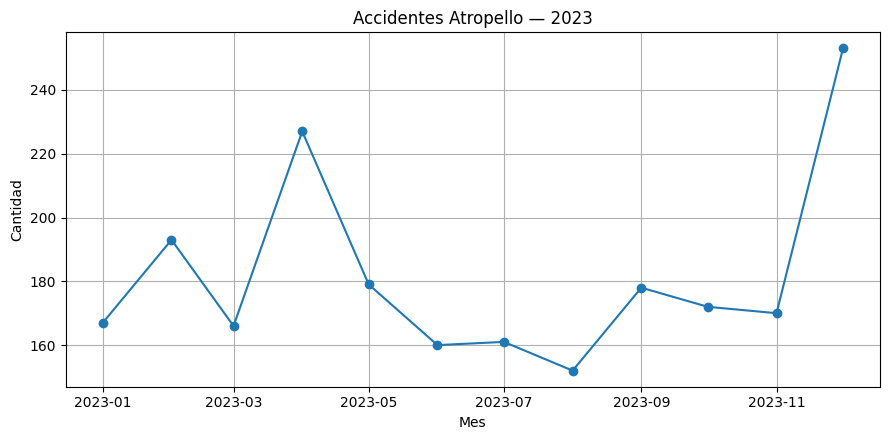

In [0]:
# INCISO 11 — Lesionados por ATROPELLO en 2024 por mes (y gráfico de línea)
# Si 2024 no existe en PERSONAS con lesionados, cae al año más reciente disponible;
# si PERSONAS no tiene lesionados, usa HECHOS como proxy (accidentes por atropello).
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

TARGET_YEAR = 2024

# --- Utilidades ---
def try_int(colname):
    return F.expr(f"try_cast({colname} as int)")

def es_atropello(col):
    return (F.upper(F.coalesce(F.col(col), F.lit(""))) == F.lit("ATROPELLO"))

print("=== Inciso 11: Lesionados por ATROPELLO, por mes ===")

# 1) ¿Podemos usar PERSONAS con is_lesionado=1?
pers = spark.table("personas")
years_p = (
    pers.select(
        try_int("anio_norm").alias("anio"),
        F.expr("try_cast(is_lesionado as int)").alias("les")
    )
    .filter(F.col("les") == 1)
    .select("anio").distinct().orderBy("anio")
)
years_p = [r["anio"] for r in years_p.collect() if r["anio"] is not None]

source_used = None
year_used = None

if TARGET_YEAR in years_p:
    source_used = "PERSONAS (lesionados reales)"
    year_used = TARGET_YEAR
elif years_p:
    source_used = "PERSONAS (lesionados reales) — 2024 no disponible; uso año más reciente"
    year_used = max(years_p)
else:
    # Fallback a HECHOS (proxy)
    he = spark.table("hechos")
    years_h = [r["anio"] for r in he.select(try_int("anio_norm").alias("anio")).distinct().orderBy("anio").collect() if r["anio"] is not None]
    if TARGET_YEAR in years_h:
        year_used = TARGET_YEAR
    elif years_h:
        year_used = max(years_h)
    else:
        raise RuntimeError("No hay años disponibles en PERSONAS ni HECHOS.")
    source_used = "HECHOS (proxy de lesionados: accidentes por atropello)"

print(f"[INFO] Fuente usada: {source_used}")
print(f"[INFO] Año analizado: {year_used}")

# 2) Cálculo mensual
if source_used.startswith("PERSONAS"):
    df = (
        pers.select(
            try_int("anio_norm").alias("anio"),
            try_int("mes_norm").alias("mes"),
            F.col("tipo_eve_norm").alias("tipo"),
            F.expr("try_cast(is_lesionado as int)").alias("les")
        )
        .filter(
            (F.col("anio") == year_used) &
            (F.col("les") == 1) &
            es_atropello("tipo")
        )
    )
    mensual = (
        df.groupBy("anio", "mes")
          .agg(F.count(F.lit(1)).alias("lesionados_atropello"))
          .orderBy("mes")
    )
    y_col = "lesionados_atropello"
else:
    he = spark.table("hechos")
    df = (
        he.select(
            try_int("anio_norm").alias("anio"),
            try_int("mes_norm").alias("mes"),
            F.col("tipo_eve_norm").alias("tipo")
        )
        .filter(
            (F.col("anio") == year_used) &
            es_atropello("tipo")
        )
    )
    mensual = (
        df.groupBy("anio", "mes")
          .agg(F.count(F.lit(1)).alias("accidentes_atropello"))
          .orderBy("mes")
    )
    y_col = "accidentes_atropello"

# 3) Columna fecha (primer día de mes) y orden
mensual = (
    mensual.withColumn("anio_mes", F.format_string("%04d-%02d", F.col("anio"), F.col("mes")))
           .withColumn("fecha", F.to_date(F.concat(F.col("anio_mes"), F.lit("-01"))))
           .orderBy("fecha")
)

print("\n=== Tabla mensual ===")
mensual.select("anio", "mes", y_col).show(24, truncate=False)

# 4) GRAFICAR (línea) con matplotlib — sin depender del UI de display
pdf = mensual.select("fecha", y_col).orderBy("fecha").toPandas()

plt.figure(figsize=(9,4.5))
plt.plot(pdf["fecha"], pdf[y_col], marker="o")
plt.title(f"{y_col.replace('_', ' ').title()} — {year_used}")
plt.xlabel("Mes")
plt.ylabel("Cantidad")
plt.grid(True)
plt.tight_layout()
plt.show()

# (Opcional) También puedes ver/usar display como gráfico de línea en l


# Inciso 12

=== Chequeo bases depuradas ===
HECHOS (llaves únicas): 7,803
PERSONAS agrupadas por llave (registros de llave): 7,620

=== Resultado del join (llaves coincidentes) ===
Llaves con al menos 1 fallecido y 1 hecho: 7,542
+----+---+-----+---------+------------+
|anio|mes|depto|tipo     |n_fallecidos|
+----+---+-----+---------+------------+
|2014|1  |1    |ATROPELLO|71          |
|2014|1  |1    |CHOQUE   |4           |
|2014|1  |1    |COLISION |111         |
|2014|1  |1    |DERRAPE  |46          |
|2014|1  |2    |ATROPELLO|5           |
|2014|1  |2    |COLISION |5           |
|2014|1  |2    |VUELCO   |2           |
|2014|1  |3    |ATROPELLO|7           |
|2014|1  |3    |COLISION |3           |
|2014|1  |4    |ATROPELLO|15          |
+----+---+-----+---------+------------+
only showing top 10 rows

=== Fallecidos por tipo de accidente ===
+----------+----------------+
|tipo      |total_fallecidos|
+----------+----------------+
|COLISION  |37997           |
|ATROPELLO |19864           |
|DERR

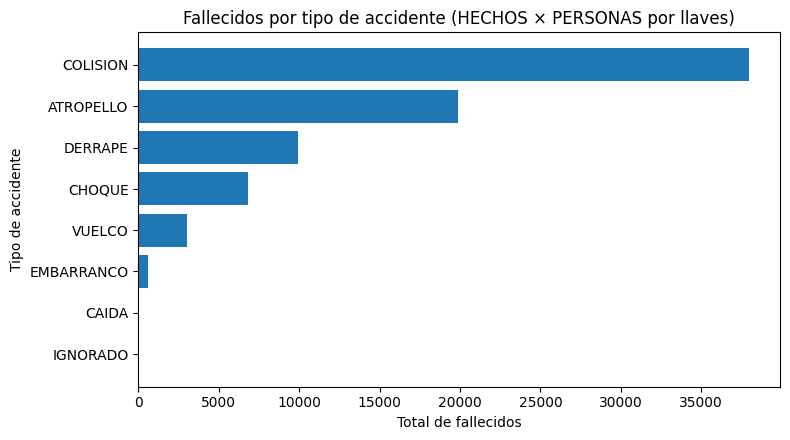

In [0]:
# INCISO 12 — Accidentes ↔ Fallecidos (join por año, mes, depto, tipo)
# - Corrige el filtro de fallecidos (1.0 como string, SI/TRUE, etc.)
# - Evita multiplicación: join de HECHOS (llaves DISTINCT) con PERSONAS agregadas por llave
# - Devuelve total de fallecidos por tipo + gráfico de barras horizontales

from pyspark.sql import functions as F

# --- Helpers ---
def as_int(c): 
    return F.col(c).cast("int")

def tipo_norm(c):
    raw = F.upper(F.trim(F.col(c)))
    return F.when(raw.isNull() | (raw == "") | (raw == "NULL") | (raw == "NAN"), None).otherwise(raw)

# --- Llaves de HECHOS (distintas por año-mes-depto-tipo) ---
hechos_keys = (
    spark.table("hechos")
         .select(
             as_int("anio_norm").alias("anio"),
             as_int("mes_norm").alias("mes"),
             as_int("depto_code").alias("depto"),
             tipo_norm("tipo_eve_norm").alias("tipo")
         )
         .filter(
             F.col("anio").isNotNull() &
             F.col("mes").between(1,12) &
             F.col("depto").isNotNull() &
             F.col("tipo").isNotNull()
         )
         .distinct()
)

# --- PERSONAS → marcar fallecidos de forma robusta y agregar por llave ---
is_falle_str = F.upper(F.trim(F.col("is_fallecido").cast("string")))
flag_falle = (
    F.when(F.col("is_fallecido").cast("double") > 0, 1)  # "1.0", 1, 1.0
     .when(is_falle_str.isin("1", "SI", "SÍ", "TRUE", "T", "Y", "YES"), 1)
     .when(F.col("is_fallecido").isNull(), 1)            # fallback: en esta base todos son fallecidos
     .otherwise(0)
)

personas_by_key = (
    spark.table("personas")
         .select(
             as_int("anio_norm").alias("anio"),
             as_int("mes_norm").alias("mes"),
             as_int("depto_code").alias("depto"),
             tipo_norm("tipo_eve_norm").alias("tipo"),
             flag_falle.alias("falle")
         )
         .filter(
             F.col("anio").isNotNull() &
             F.col("mes").between(1,12) &
             F.col("depto").isNotNull() &
             F.col("tipo").isNotNull()
         )
         .groupBy("anio","mes","depto","tipo")
         .agg(F.sum("falle").alias("n_fallecidos"))
)

print("=== Chequeo bases depuradas ===")
print(f"HECHOS (llaves únicas): {hechos_keys.count():,}")
print(f"PERSONAS agrupadas por llave (registros de llave): {personas_by_key.count():,}")

# --- JOIN por llaves: (anio, mes, depto, tipo) ---
join_cols = ["anio","mes","depto","tipo"]
hxP = hechos_keys.join(personas_by_key, on=join_cols, how="inner")

print("\n=== Resultado del join (llaves coincidentes) ===")
print(f"Llaves con al menos 1 fallecido y 1 hecho: {hxP.count():,}")
hxP.orderBy(*join_cols).show(10, truncate=False)

# --- Total de fallecidos por tipo de accidente ---
fallecidos_por_tipo = (
    hxP.groupBy("tipo")
       .agg(F.sum("n_fallecidos").alias("total_fallecidos"))
       .orderBy(F.desc("total_fallecidos"))
)

print("\n=== Fallecidos por tipo de accidente ===")
fallecidos_por_tipo.show(truncate=False)

# === Gráfico (barras horizontales) ===
# Opción A: display() en Databricks:
# display(fallecidos_por_tipo)  # en la UI elige "Bar chart" y orientación Horizontal

# Opción B: matplotlib inline (si tu cluster lo permite):
import matplotlib.pyplot as plt
pdf = fallecidos_por_tipo.toPandas()

plt.figure(figsize=(8, 4.5))
plt.barh(pdf["tipo"], pdf["total_fallecidos"])
plt.gca().invert_yaxis()
plt.xlabel("Total de fallecidos")
plt.ylabel("Tipo de accidente")
plt.title("Fallecidos por tipo de accidente (HECHOS × PERSONAS por llaves)")
plt.tight_layout()
plt.show()


# Inciso 13

In [0]:
# INCISO 13 — Clasificar accidentes por franja horaria con withColumn
# Mañana [6-12), Tarde [12-18), Noche [18-24), Madrugada [0-6)
# Salida: conteo por franja + chequeos de calidad.

from pyspark.sql import functions as F

hechos = spark.table("hechos")

# 1) Asegurar hora numérica robusta (extrae 0–23 al inicio del string; invalida lo fuera de rango)
hechos_franja = (
    hechos
    .withColumn("hora_str", F.col("hora_clean").cast("string"))
    .withColumn("hora_num_raw", F.regexp_extract(F.col("hora_str"), r"^\d{1,2}", 0).cast("int"))
    .withColumn("hora_valid", F.when((F.col("hora_num_raw") >= 0) & (F.col("hora_num_raw") < 24), F.col("hora_num_raw")))
    .withColumn(
        "franja_calc",
        F.when((F.col("hora_valid") >= 6)  & (F.col("hora_valid") < 12), F.lit("MAÑANA"))
         .when((F.col("hora_valid") >= 12) & (F.col("hora_valid") < 18), F.lit("TARDE"))
         .when((F.col("hora_valid") >= 18) & (F.col("hora_valid") < 24), F.lit("NOCHE"))
         .when((F.col("hora_valid") >= 0)  & (F.col("hora_valid") < 6),  F.lit("MADRUGADA"))
         .otherwise(F.lit("SIN_HORA"))
    )
)

# 2) Conteo por franja
franjas_cnt = (
    hechos_franja
    .groupBy("franja_calc")
    .count()
    .orderBy(F.desc("count"))
)

print("=== Accidentes por franja horaria (calculada) ===")
franjas_cnt.show(truncate=False)

# 3) (Opcional) Comparar con la columna ya existente 'franja_horaria' del master, si viene poblada
if "franja_horaria" in hechos.columns:
    mismatch = (
        hechos_franja
        .filter(F.col("franja_horaria").isNotNull() & (F.col("franja_calc") != F.col("franja_horaria")))
        .count()
    )
    total_hora_valida = hechos_franja.filter(F.col("hora_valid").isNotNull()).count()
    print(f"\n[Chequeo] Registros con hora válida: {total_hora_valida:,}")
    print(f"[Chequeo] Diferencias franja_calc vs franja_horaria existente: {mismatch:,}")

# 4) (Opcional) Gráfico en Databricks
# display(franjas_cnt)  # En la UI elige "Bar chart" → X: franja_calc, Y: count

# 5) (Opcional) Crear/actualizar vista temporal para usar en otros incisos
hechos_franja.createOrReplaceTempView("hechos_franja")


=== Accidentes por franja horaria (calculada) ===
+-----------+-----+
|franja_calc|count|
+-----------+-----+
|NOCHE      |29340|
|TARDE      |20542|
|MAÑANA     |14768|
|MADRUGADA  |12082|
|SIN_HORA   |27   |
+-----------+-----+


[Chequeo] Registros con hora válida: 76,732
[Chequeo] Diferencias franja_calc vs franja_horaria existente: 0


# Inciso 14

In [0]:
# INCISO 14 — Ratio de fallecidos por accidente por departamento
# (fallecidos / accidentes). Guardar resultado en Parquet.

from pyspark.sql import functions as F

# Tablas creadas en incisos previos
hechos   = spark.table("hechos")
personas = spark.table("personas")

# Helper: extrae enteros limpios y valida rango de departamento [1..22]
def dep_int(col):
    return F.regexp_extract(F.col(col).cast("string"), r"\d+", 0).cast("int")

# 1) Accidentes por departamento (cada fila en HECHOS = 1 accidente)
accidentes_dep = (
    hechos
    .withColumn("dep_code", dep_int("depto_code"))
    .withColumn("dep_name", F.col("depto_name_std"))
    .filter((F.col("dep_code") >= 1) & (F.col("dep_code") <= 22))
    .groupBy("dep_code", "dep_name")
    .count()
    .withColumnRenamed("count", "accidentes")
)

# 2) Fallecidos por departamento (PERSONAS: is_fallecido == 1)
fallecidos_dep = (
    personas
    .withColumn("dep_code", dep_int("depto_code"))
    .withColumn("dep_name", F.col("depto_name_std"))
    .withColumn("fallecido_flag", F.coalesce(F.col("is_fallecido").cast("double"), F.lit(0.0)))
    .filter((F.col("dep_code") >= 1) & (F.col("dep_code") <= 22))
    .filter(F.col("fallecido_flag") == 1.0)
    .groupBy("dep_code", "dep_name")
    .count()
    .withColumnRenamed("count", "fallecidos")
)

# 3) Join + cálculo de ratio
ratio_dep = (
    accidentes_dep
    .join(fallecidos_dep, ["dep_code", "dep_name"], "left")
    .na.fill({"fallecidos": 0})
    .withColumn(
        "ratio_fallecidos_por_accidente",
        F.when(F.col("accidentes") > 0, F.col("fallecidos") / F.col("accidentes"))
    )
    .orderBy(F.desc("ratio_fallecidos_por_accidente"))
)

print("=== Top 10 ratio fallecidos/accidente por depto ===")
ratio_dep.show(10, truncate=False)

# 4) Guardar en Parquet (Volumes)
OUT_PATH = "/Volumes/workspace/default/lab8/out/ratio_fallecidos_por_accidente.parquet"
ratio_dep.write.mode("overwrite").parquet(OUT_PATH)
print(f"[OK] Guardado en: {OUT_PATH}")

# 5) (Opcional) Verificación re-lectura + vista temporal para siguientes incisos
chk = spark.read.parquet(OUT_PATH)
chk.orderBy(F.desc("ratio_fallecidos_por_accidente")).show(5, truncate=False)

ratio_dep.createOrReplaceTempView("ratio_dep")
# display(ratio_dep)  # En la UI puedes graficar barras por dep_name (X) y ratio (Y).


=== Top 10 ratio fallecidos/accidente por depto ===
+--------+-------------+----------+----------+------------------------------+
|dep_code|dep_name     |accidentes|fallecidos|ratio_fallecidos_por_accidente|
+--------+-------------+----------+----------+------------------------------+
|14      |QUICHE       |1337      |2534      |1.8952879581151831            |
|7       |SOLOLA       |1127      |1982      |1.758651286601597             |
|16      |ALTA VERAPAZ |2615      |4566      |1.7460803059273422            |
|15      |BAJA VERAPAZ |1061      |1803      |1.6993402450518378            |
|2       |EL PROGRESO  |1372      |2268      |1.653061224489796             |
|13      |HUEHUETENANGO|1336      |2201      |1.6474550898203593            |
|22      |JUTIAPA      |1657      |2647      |1.5974652987326494            |
|5       |ESCUINTLA    |4439      |7007      |1.5785086731245777            |
|6       |SANTA ROSA   |2052      |3230      |1.5740740740740742            |
|8       |TO

# Inciso 15

=== Grupos de edad: fallecidos vs lesionados (tabla) ===
+----------+----------+----------+-----+
|grupo_edad|fallecidos|lesionados|orden|
+----------+----------+----------+-----+
|0-4       |2265      |0         |0    |
|5-14      |6126      |0         |1    |
|15-24     |25443     |0         |2    |
|25-34     |22779     |0         |3    |
|35-44     |12188     |0         |4    |
|45-54     |6916      |0         |5    |
|55-64     |4362      |0         |6    |
|65-74     |2590      |0         |7    |
|75-84     |1256      |0         |8    |
|85+       |324       |0         |9    |
+----------+----------+----------+-----+



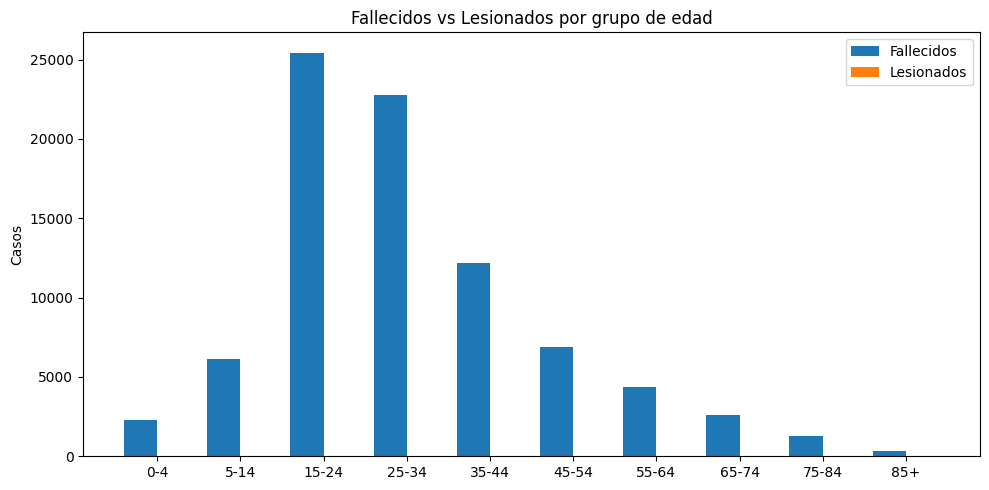

In [0]:
# INCISO 15 — Grupos de edad más afectados (fallecidos vs lesionados) + GRÁFICO
# - Calcula grupos de edad (0–4, 5–14, …, 85+)
# - Compara conteos de fallecidos y lesionados
# - Grafica barras lado a lado (matplotlib)
# - Alternativa con display() al final por si prefieres el gráfico “nativo” de Databricks

from pyspark.sql import functions as F
import numpy as np
import matplotlib.pyplot as plt

# 1) Base personas y limpieza de campos
personas = spark.table("personas")

df = (
    personas
    .withColumn("edad", F.floor(F.col("edad_per_num").cast("double")))
    .withColumn("fallecido_flag", F.coalesce(F.col("is_fallecido").cast("double"), F.lit(0.0)))
    .withColumn("lesionado_flag", F.coalesce(F.col("is_lesionado").cast("double"), F.lit(0.0)))
    .filter((F.col("edad") >= 0) & (F.col("edad") <= 110))
)

# 2) Grupos de edad
df = df.withColumn(
    "grupo_edad",
    F.when(F.col("edad") < 5,  "0-4")
     .when(F.col("edad") < 15, "5-14")
     .when(F.col("edad") < 25, "15-24")
     .when(F.col("edad") < 35, "25-34")
     .when(F.col("edad") < 45, "35-44")
     .when(F.col("edad") < 55, "45-54")
     .when(F.col("edad") < 65, "55-64")
     .when(F.col("edad") < 75, "65-74")
     .when(F.col("edad") < 85, "75-84")
     .otherwise("85+")
)

orden = (
    F.when(F.col("grupo_edad") == "0-4", 0)
     .when(F.col("grupo_edad") == "5-14", 1)
     .when(F.col("grupo_edad") == "15-24", 2)
     .when(F.col("grupo_edad") == "25-34", 3)
     .when(F.col("grupo_edad") == "35-44", 4)
     .when(F.col("grupo_edad") == "45-54", 5)
     .when(F.col("grupo_edad") == "55-64", 6)
     .when(F.col("grupo_edad") == "65-74", 7)
     .when(F.col("grupo_edad") == "75-84", 8)
     .otherwise(9)
)

# 3) Agregación comparativa
grupos = (
    df.groupBy("grupo_edad")
      .agg(
          F.sum(F.when(F.col("fallecido_flag") == 1.0, 1).otherwise(0)).alias("fallecidos"),
          F.sum(F.when(F.col("lesionado_flag") == 1.0, 1).otherwise(0)).alias("lesionados")
      )
      .withColumn("orden", orden)
      .orderBy("orden")
)

print("=== Grupos de edad: fallecidos vs lesionados (tabla) ===")
grupos.show(truncate=False)

# 4) GRÁFICO — barras lado a lado con matplotlib
pd_df = grupos.select("grupo_edad","fallecidos","lesionados","orden") \
              .orderBy("orden").toPandas()

x = np.arange(len(pd_df))            # posiciones en X
width = 0.4                          # ancho de cada barra

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, pd_df["fallecidos"], width, label="Fallecidos")
plt.bar(x + width/2, pd_df["lesionados"], width, label="Lesionados")
plt.xticks(x, pd_df["grupo_edad"])
plt.ylabel("Casos")
plt.title("Fallecidos vs Lesionados por grupo de edad")
plt.legend()
plt.tight_layout()
plt.show()

# 5) OPCIONAL: gráfico “nativo” con display() de Databricks
#    (te abre el panel de gráficos; selecciona tipo 'Bar', Key=grupo_edad, Series=fallecidos y lesionados)
# display(grupos.select("grupo_edad","fallecidos","lesionados").orderBy("orden"))


## **Inicso 16**

=== Accidentes y Fallecidos por Zona — Municipio de Guatemala ===
+--------+----------+----------+
|zona_int|accidentes|fallecidos|
+--------+----------+----------+
|1       |190       |0         |
|2       |34        |0         |
|3       |61        |0         |
|4       |36        |0         |
|5       |70        |0         |
|6       |130       |0         |
|7       |192       |0         |
|8       |33        |0         |
|9       |52        |0         |
|10      |51        |0         |
|11      |121       |0         |
|12      |211       |0         |
|13      |71        |0         |
|14      |5         |0         |
|15      |20        |0         |
|16      |32        |0         |
|17      |51        |0         |
|18      |238       |0         |
|19      |21        |0         |
|21      |26        |0         |
|24      |15        |0         |
|25      |39        |0         |
+--------+----------+----------+



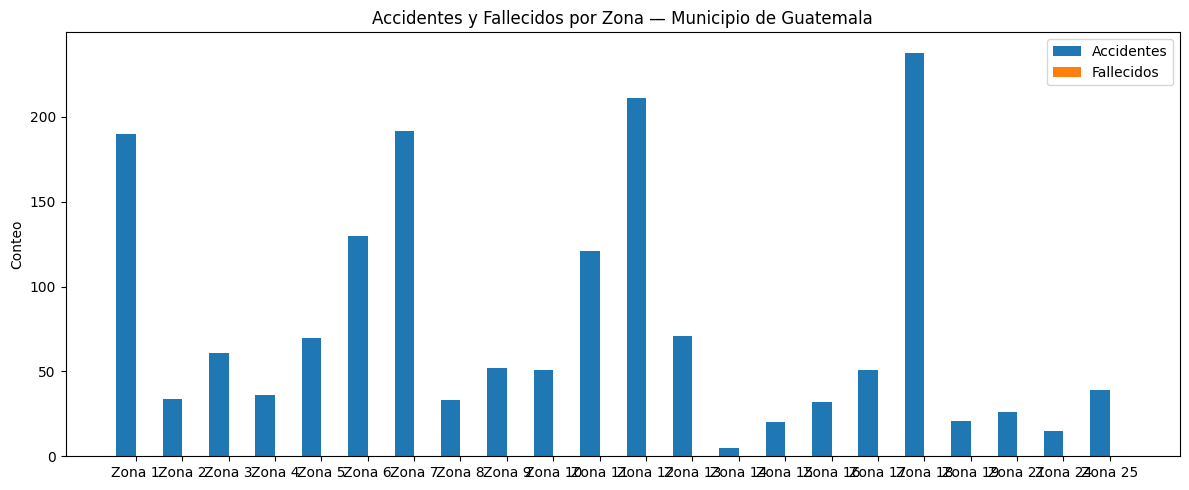

In [0]:
# INCISO 16 — Municipio de Guatemala: Accidentes y Fallecidos por ZONA (sin try_cast, robusto a vacíos)
from pyspark.sql import functions as F
import numpy as np
import matplotlib.pyplot as plt

# --- Helper: castea a INT SOLO si hay dígitos ('' o basura -> NULL) ---
def safe_int_from_any(colname: str):
    s = F.regexp_extract(F.coalesce(F.col(colname).cast("string"), F.lit("")), r"\d+", 0)
    return F.when(F.length(s) == 0, F.lit(None)).otherwise(s.cast("int"))

hechos   = spark.table("hechos")
personas = spark.table("personas")

# == HECHOS: filtrar municipio de Guatemala (depto=1, muni=101) ==
hechos_gua = (
    hechos
    .withColumn("depto_int", safe_int_from_any("depto_code"))
    .withColumn("muni_int",  safe_int_from_any("muni_code"))
    .withColumn("zona_int",  safe_int_from_any("zona_ciudad_num"))
    .filter( (F.col("depto_int")==1) & (F.col("muni_int")==101) )
)

acc_zona = (
    hechos_gua
    .filter( F.col("zona_int").isNotNull() & (F.col("zona_int") > 0) & (F.col("zona_int") != 99) )
    .groupBy("zona_int")
    .agg(F.count(F.lit(1)).alias("accidentes"))
)

# == PERSONAS: fallecidos en el mismo municipio ==
pers_gua = (
    personas
    .withColumn("depto_int", safe_int_from_any("depto_code"))
    .withColumn("muni_int",  safe_int_from_any("muni_code"))
    .withColumn("zona_persona", safe_int_from_any("zona_ciudad_num"))
    # Normalizar is_fallecido a 1/0 de forma segura
    .withColumn(
        "is_fallecido_num",
        F.when(F.lower(F.col("is_fallecido").cast("string")).isin("1","1.0","true","t","sí","si"), F.lit(1)).otherwise(F.lit(0))
    )
    .filter( (F.col("depto_int")==1) & (F.col("muni_int")==101) & (F.col("is_fallecido_num")==1) )
)

# Fallback de zona: si en PERSONAS no hay zona, traemos la de HECHOS por (anio, mes, depto, muni)
join_keys = [k for k in ["anio_norm","mes_norm","depto_int","muni_int"] if k in hechos_gua.columns]

hechos_keys = (
    hechos_gua
    .select(*join_keys, "zona_int")
    .dropDuplicates(join_keys + ["zona_int"])
)

pers_enri = (
    pers_gua
    .select(*join_keys, "zona_persona")
    .join(hechos_keys, on=join_keys, how="left")
    .withColumn("zona_final", F.coalesce(F.col("zona_persona"), F.col("zona_int")))
)

falle_zona = (
    pers_enri
    .filter( F.col("zona_final").isNotNull() & (F.col("zona_final") > 0) & (F.col("zona_final") != 99) )
    .groupBy(F.col("zona_final").alias("zona_int"))
    .agg(F.count(F.lit(1)).alias("fallecidos"))
)

# == Resultado combinado ==
res = (
    acc_zona.join(falle_zona, on="zona_int", how="outer")
            .na.fill({"accidentes": 0, "fallecidos": 0})
            .orderBy("zona_int")
)

print("=== Accidentes y Fallecidos por Zona — Municipio de Guatemala ===")
res.show(50, truncate=False)

# === Gráfico: barras lado a lado ===
pdf = res.toPandas()
x = np.arange(len(pdf))
w = 0.42

plt.figure(figsize=(12, 5))
plt.bar(x - w/2, pdf["accidentes"], width=w, label="Accidentes")
plt.bar(x + w/2, pdf["fallecidos"], width=w, label="Fallecidos")
plt.xticks(x, [f"Zona {z}" for z in pdf["zona_int"]], rotation=0)
plt.ylabel("Conteo")
plt.title("Accidentes y Fallecidos por Zona — Municipio de Guatemala")
plt.legend()
plt.tight_layout()
plt.show()

# Alternativa en Databricks:
# display(res)  # Elegir "Bar", Key=zona_int, Series=accidentes y fallecidos


## **Inciso 17**

[INFO] Accidentes deduplicados (H/M): 3,221


sexo_accidente,accidentes,porcentaje
HOMBRE,3140,97.49
MUJER,81,2.51


[OK] Guardado en Parquet: /Volumes/workspace/default/lab8/out/pct_accidentes_sexo_conductor.parquet


sexo_accidente,accidentes,porcentaje
HOMBRE,3140,97.49
MUJER,81,2.51


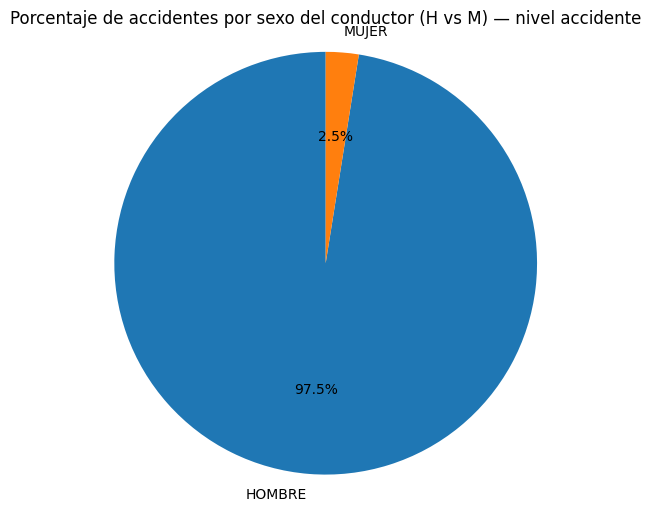

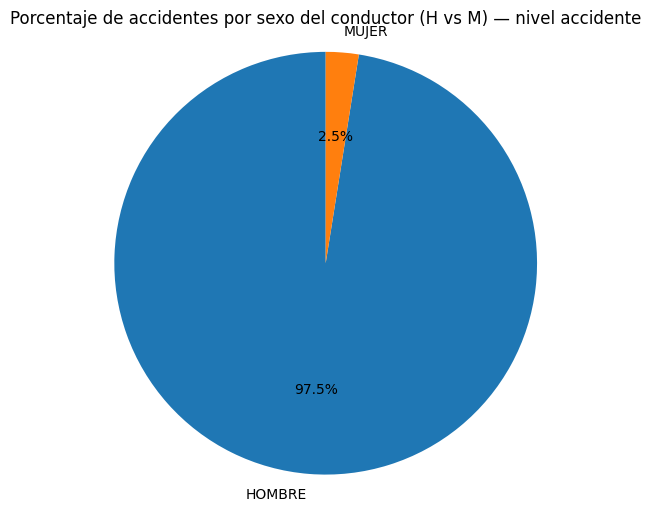

In [0]:
# INCISO 17 — % de ACCIDENTES con conductor HOMBRE vs MUJER (tabla vehículos) + GRÁFICO PIE
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# 1) Cargar vista vehículos
veh = spark.table("vehiculos")

# 2) Normalizador robusto del sexo por FILA DE VEHÍCULO
def norm_sex(col):
    s = F.lower(F.trim(F.coalesce(col.cast("string"), F.lit(""))))
    hombre = (s.rlike(r'^(h|hombre|masculino|male|m)$') | s.isin("1", "1.0"))
    mujer  = (s.rlike(r'^(f|mujer|femenina|female|fem)$') | s.isin("2", "2.0"))
    return F.when(hombre, "HOMBRE").when(mujer, "MUJER").otherwise(F.lit(None))

# 3) Detección de columna de sexo del conductor
sexo_col = "sexo_pil_norm" if "sexo_pil_norm" in veh.columns else ("sexo_con" if "sexo_con" in veh.columns else None)
if sexo_col is None:
    raise ValueError("No encuentro columna de sexo del conductor en 'vehiculos' (busqué 'sexo_pil_norm' y 'sexo_con').")

veh_n = veh.withColumn("sexo_driver", norm_sex(F.col(sexo_col)))

# 4) Construir llave de ACCIDENTE (deduplicación a nivel evento)
preferidas = ["anio_norm","mes_norm","dia_norm","hora_clean","depto_code","muni_code","tipo_eve_norm"]
key_cols = [c for c in preferidas if c in veh_n.columns]
if len(key_cols) < 4:
    fallback = ["anio_norm","mes_norm","depto_code","tipo_eve_norm"]
    key_cols = [c for c in fallback if c in veh_n.columns]
if len(key_cols) == 0:
    raise ValueError("No hay columnas suficientes para construir una llave de accidente.")

veh_keyed = veh_n.withColumn(
    "acc_id",
    F.concat_ws("-", *[F.coalesce(F.col(c).cast("string"), F.lit("")) for c in key_cols])
)

# 5) Reducir a NIVEL ACCIDENTE: HOMBRE / MUJER / MIXTO / NULL
acc_sex = (
    veh_keyed
    .groupBy("acc_id")
    .agg(
        F.max(F.when(F.col("sexo_driver")=="HOMBRE", 1).otherwise(0)).alias("has_h"),
        F.max(F.when(F.col("sexo_driver")=="MUJER", 1).otherwise(0)).alias("has_m")
    )
    .withColumn(
        "sexo_accidente",
        F.when((F.col("has_h")==1) & (F.col("has_m")==0), "HOMBRE")
         .when((F.col("has_h")==0) & (F.col("has_m")==1), "MUJER")
         .when((F.col("has_h")==1) & (F.col("has_m")==1), "MIXTO")
         .otherwise(F.lit(None))
    )
)

# 6) Solo HOMBRE/MUJER
acc_hm = acc_sex.filter(F.col("sexo_accidente").isin("HOMBRE","MUJER"))

# 7) Conteos y % a nivel accidente
res = acc_hm.groupBy("sexo_accidente").agg(F.count(F.lit(1)).alias("accidentes"))
total_acc = res.agg(F.sum("accidentes").alias("tot")).collect()[0]["tot"]

pct = (
    res.withColumn("porcentaje", F.round(F.col("accidentes")/F.lit(total_acc)*100, 2))
      .orderBy(F.desc("porcentaje"))
)

print(f"[INFO] Accidentes deduplicados (H/M): {total_acc:,}")
display(pct)

# 8) Guardar a Parquet y recargar
OUT = "/Volumes/workspace/default/lab8/out/pct_accidentes_sexo_conductor.parquet"
pct.write.mode("overwrite").parquet(OUT)
print(f"[OK] Guardado en Parquet: {OUT}")

pct_loaded = spark.read.parquet(OUT).orderBy(F.desc("porcentaje"))
display(pct_loaded)  # puedes cambiar a 'Pie' en el UI si prefieres

# 9) GRÁFICO PIE (Matplotlib) — se renderiza enseguida
pdf = pct_loaded.toPandas()
fig, ax = plt.subplots(figsize=(6,6))
ax.pie(
    pdf["porcentaje"],
    labels=pdf["sexo_accidente"],
    autopct="%1.1f%%",
    startangle=90
)
ax.set_title("Porcentaje de accidentes por sexo del conductor (H vs M) — nivel accidente")
ax.axis("equal")  # Pie circular
display(fig)
